
# 🧠 LSTM Player and Ball Movement Prediction

This notebook:
- Loads your cleaned CSV file of 20 frames
- Parses and flattens [x; y] positions
- Normalizes all coordinates
- Trains an LSTM model on sequences of 10 frames
- Predicts 4 full frames (frames 17–20)
- Denormalizes predictions
- Compares predicted vs actual positions


In [1]:

from google.colab import files
uploaded = files.upload()


Saving subset1_cleaned_1.csv to subset1_cleaned_1.csv


In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [3]:

# Load CSV
df = pd.read_csv("subset1_cleaned_1.csv")

# Convert string coordinates like "[123;456]" to [123.0, 456.0]
def parse_coords(cell):
    if isinstance(cell, str) and (';' in cell or ',' in cell):
        cell = cell.strip('[]')
        sep = ';' if ';' in cell else ','
        try:
            return [float(x) for x in cell.split(sep)]
        except ValueError:
            return np.nan
    return np.nan

parsed_df = df.drop(columns=['frame_index']).applymap(parse_coords)

# Drop poorly filled columns, then fill remaining NaNs
parsed_df = parsed_df.loc[:, parsed_df.notna().mean() >= 0.8]
parsed_df = parsed_df.fillna(method='ffill').fillna(method='bfill')

# Flatten to [x1, y1, x2, y2, ..., xN, yN]
flattened_data = np.array([
    np.concatenate(row) for row in parsed_df.values
])
flattened_data.shape


<ipython-input-3-3b2628eb891a>:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  parsed_df = df.drop(columns=['frame_index']).applymap(parse_coords)
<ipython-input-3-3b2628eb891a>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  parsed_df = parsed_df.fillna(method='ffill').fillna(method='bfill')


(20, 38)

In [4]:

# Normalize data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(flattened_data)

# Sanity check
normalized_data[:2]


array([[0.94526316, 0.29813665, 0.        , 0.        , 0.11458333,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.02054795, 0.        , 0.        ,
        0.        , 0.68678161, 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.00406504, 0.        , 0.        ,
        1.        , 0.        , 0.47368421],
       [0.96315789, 0.47826087, 0.04294479, 0.075     , 0.13194444,
        0.04347826, 0.02922078, 0.03703704, 0.04991394, 0.01324503,
        0.04225352, 0.01941748, 0.00684932, 0.15      , 0.11838791,
        0.12048193, 0.75287356, 0.09433962, 0.04863222, 0.        ,
        0.0327381 , 0.0952381 , 1.        , 0.14141414, 0.02272727,
        0.        , 0.05454545, 0.09090909, 0.04859335, 0.        ,
        0.98174905, 0.09090909, 0.        , 0.08823529, 0.03246753,
   

In [5]:

# Prepare training data: sequences of 10 to predict next
X_train, y_train = [], []
for i in range(6):  # frames 1–6 to predict 11–16
    X_train.append(normalized_data[i:i+10])
    y_train.append(normalized_data[i+10])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Initial input for recursive prediction
X_test_start = normalized_data[6:16]


In [6]:

# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(10, X_train.shape[2]), return_sequences=False),
    Dense(X_train.shape[2])
])
model.compile(optimizer=Adam(0.001), loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:

# Predict 4 frames recursively
predictions = []
input_seq = X_test_start.copy()

for _ in range(4):  # predict frames 17–20
    pred = model.predict(input_seq[np.newaxis, ...], verbose=0)[0]
    predictions.append(pred)
    input_seq = np.vstack([input_seq[1:], pred])

# Denormalize predictions
predictions = scaler.inverse_transform(np.array(predictions))

# Actual frames 17–20 for comparison
actual = flattened_data[16:20]


In [8]:

# Compare predictions to actual for all entities
for i in range(4):
    print(f"Frame {17+i}:")
    print("  Predicted:", predictions[i].reshape(-1, 2))
    print("  Actual:   ", actual[i].reshape(-1, 2))
    print()


Frame 17:
  Predicted: [[ 395.053    850.74396]
 [1082.2435   529.9022 ]
 [ 641.3695   749.15656]
 [1409.0476   440.58014]
 [ 868.31195  702.21313]
 [1528.9579   521.7464 ]
 [ 463.16006  335.73026]
 [1040.4286   705.20105]
 [1511.8304   714.20935]
 [1016.83484  406.20993]
 [1354.927    474.26096]
 [ 181.31854  815.0462 ]
 [ 454.30737  544.38605]
 [ 260.20822  562.5368 ]
 [1302.1135   393.9701 ]
 [ 807.4635   861.8734 ]
 [ 885.2228   467.17212]
 [ 358.3116   236.99852]
 [1061.5537   243.12363]]
  Actual:    [[ 452.   855. ]
 [1088.5  529.5]
 [ 612.5  750. ]
 [1421.5  441. ]
 [ 881.5  704.5]
 [1526.5  521.5]
 [ 459.   336.5]
 [1044.   704. ]
 [1506.   716. ]
 [1018.   408. ]
 [1378.5  474.5]
 [ 178.   822.5]
 [ 464.   546. ]
 [ 255.5  560.5]
 [1327.   395. ]
 [ 787.5  866.5]
 [ 890.5  468.5]
 [ 364.5  234.5]
 [1071.5  244.5]]

Frame 18:
  Predicted: [[ 298.57065  844.1055 ]
 [1081.0115   530.4923 ]
 [ 635.97614  751.33386]
 [1412.3779   441.0109 ]
 [ 865.05133  705.0468 ]
 [1533.1814   5

In [9]:

# Save predictions to CSV for external use
pred_df = pd.DataFrame(predictions, columns=parsed_df.columns.repeat(2) + ['_x', '_y'] * (predictions.shape[1] // 2))
pred_df.to_csv("predicted_frames_17_to_20.csv", index=False)
files.download("predicted_frames_17_to_20.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

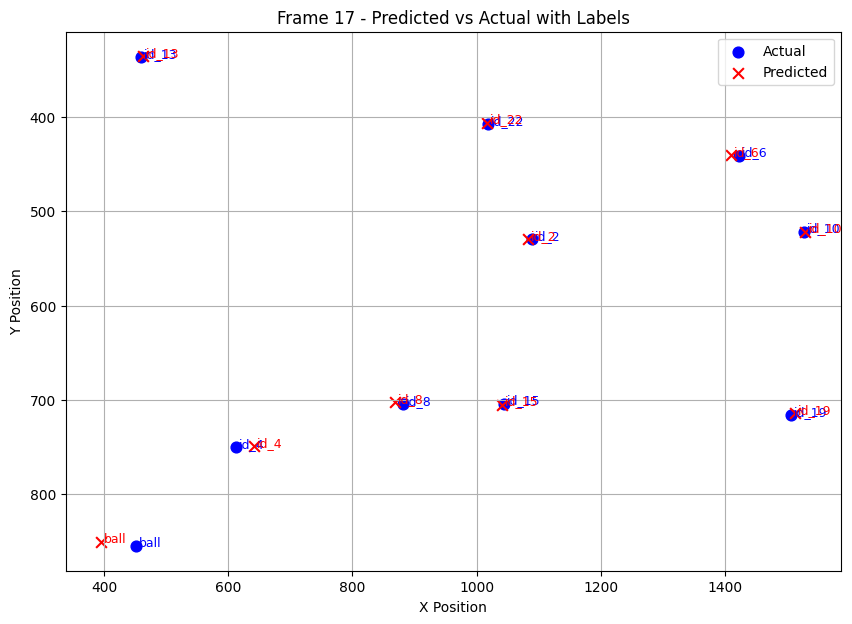

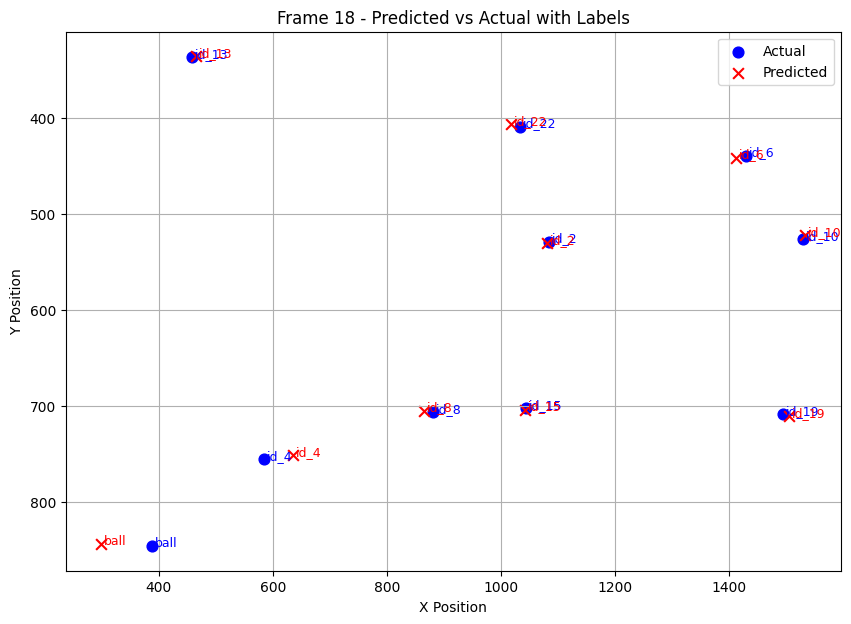

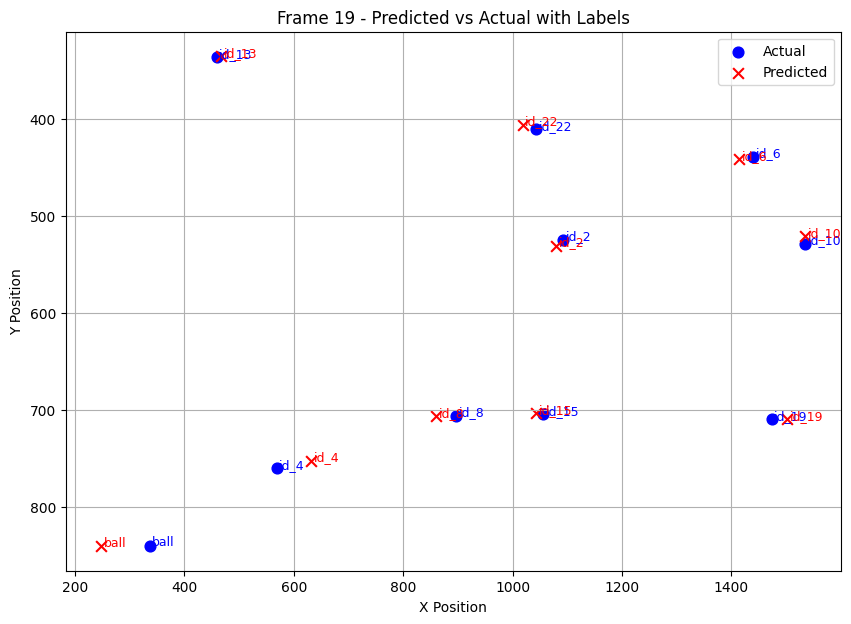

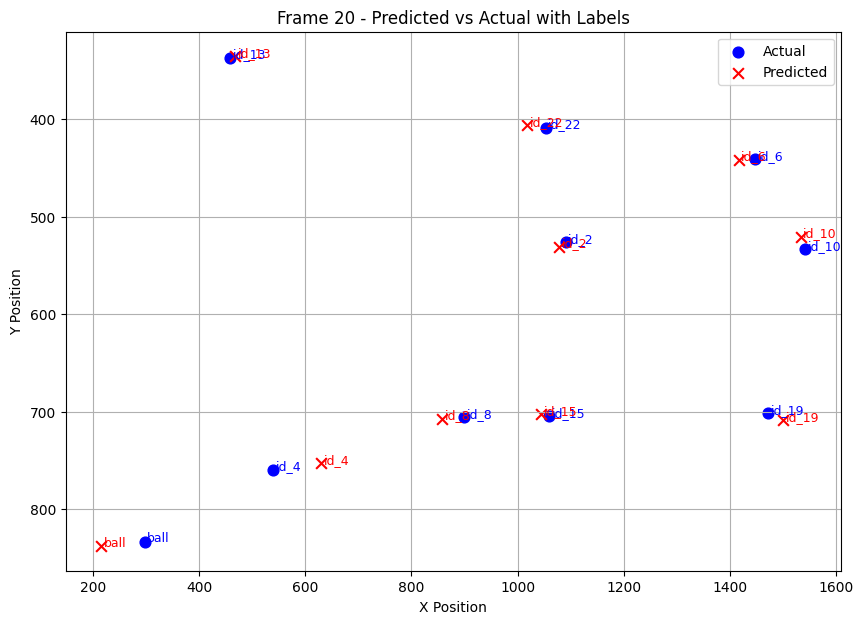

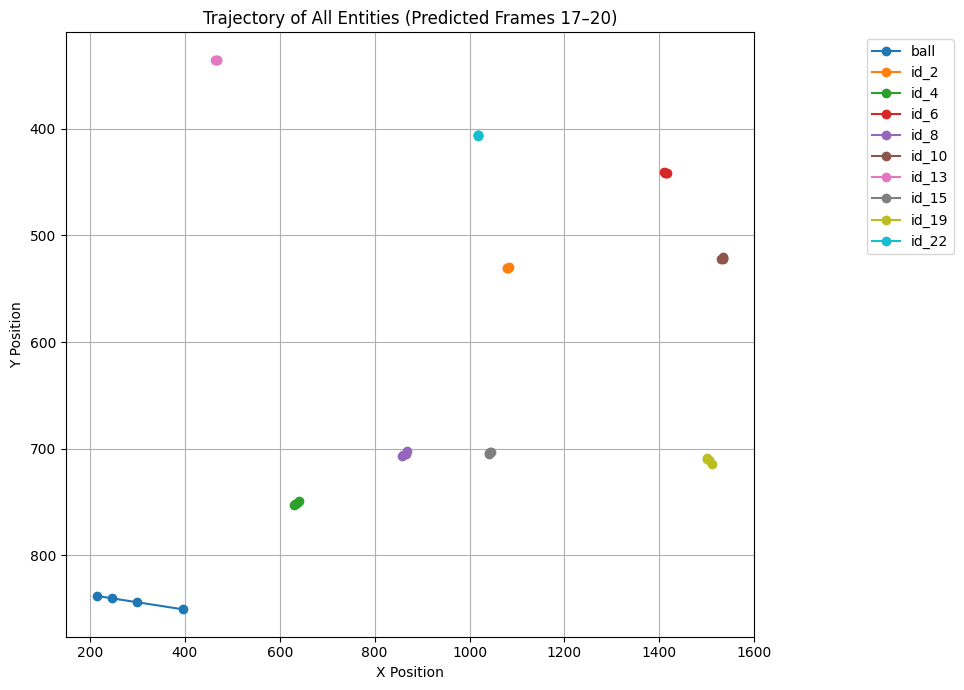

In [10]:

import matplotlib.pyplot as plt

# Use entity names from columns (player/ball labels)
entity_names = [col.replace("_x", "") for col in parsed_df.columns[::2]]

# Per-frame comparison plots with labels
for i in range(4):  # frames 17–20
    plt.figure(figsize=(10, 7))
    actual_pts = actual[i].reshape(-1, 2)
    pred_pts = predictions[i].reshape(-1, 2)

    for j in range(len(entity_names)):
        ax, ay = actual_pts[j]
        px, py = pred_pts[j]
        plt.scatter(ax, ay, color='blue', label='Actual' if j == 0 else "", s=60)
        plt.scatter(px, py, color='red', marker='x', label='Predicted' if j == 0 else "", s=60)
        plt.text(ax+5, ay, f"{entity_names[j]}", fontsize=9, color='blue')
        plt.text(px+5, py, f"{entity_names[j]}", fontsize=9, color='red')

    plt.title(f"Frame {17+i} - Predicted vs Actual with Labels")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

# --- Final graph: show trajectories for all entities over 4 predicted frames ---
plt.figure(figsize=(10, 7))
for j in range(len(entity_names)):
    traj = predictions[:, j*2:j*2+2]  # x, y over 4 frames
    plt.plot(traj[:, 0], traj[:, 1], marker='o', label=entity_names[j])

plt.title("Trajectory of All Entities (Predicted Frames 17–20)")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
plt.grid(True)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
